In [ ]:
!pip3 install torch torchvision torchaudio

In [9]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from rsvg import rsvg

# inicia o estado

In [10]:
from qiskit.visualization import plot_state_city
from rsvg import rsvg
target_state = rsvg(2)
target_op = np.outer(target_state.conj(), target_state)
target_op = torch.tensor(target_op)
print(target_state)
print(target_op)
print('Traço(target_op) = ',np.trace(target_op@target_op))


[-0.4110384 -0.51318623j  0.29168617+0.69469886j]
tensor([[ 0.4323+0.0000j, -0.4764-0.1359j],
        [-0.4764+0.1359j,  0.5677+0.0000j]], dtype=torch.complex128)
Traço(target_op) =  (1+0j)


In [ ]:
plot_state_city(target_op.detach().numpy(), title='Matriz Densidade')


Para estados puros, a fidelidade é igual ao quadrado do valor esperado.

valor esperado pode ser calculado diretamente do VQA.

In [ ]:
def fidelidade(params, target_op):
    params = Variable(torch.tensor(params), requires_grad=True)
    return circuit(params, M=target_op).item()

def init_state_params():
    params = np.random.normal(0,np.pi/2, 3)
    params = Variable(torch.tensor(params), requires_grad=True)
    target_state = rsvg(2)
    target_op = np.outer(target_state.conj(), target_state)
    target_op = torch.tensor(target_op)
    return target_op, params

device = qml.device('qiskit.aer', wires=3, backend='qasm_simulator')
@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    return qml.expval(qml.Hermitian(M, wires=[0]))

def cost(params,target_op):
    L = (1-(circuit(params, M=target_op)))**2
    return L

def train(params,target_op):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params,target_op)
    best_params = 1*params
    for epoch in range(30):
        opt.zero_grad()
        loss = cost(params,target_op)
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    print(epoch, loss.item())
    return best_params, best_loss


In [54]:
target_op, params = init_state_params()
best_params, best_loss = train(params,target_op)
print(params)
print(best_params)
f = fidelidade(best_params, target_op)
print(f)

29 0.00021457672119139974
tensor([ 1.4005, -0.2544, -2.3242], dtype=torch.float64, requires_grad=True)
tensor([ 1.3391, -0.1763, -2.0870], dtype=torch.float64,
       grad_fn=<MulBackward0>)


TypeError: 'float' object is not callable

In [56]:
import numpy as np
from qiskit import QuantumCircuit

circuit = QuantumCircuit(1)
circuit.initialize([1/np.sqrt(2), -1/np.sqrt(2)], 0)
circuit.draw()


┌──────────────────────────────┐
q: ┤ Initialize(0.70711,-0.70711) ├
   └──────────────────────────────┘

In [65]:
import numpy as np
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.initialize([0, 1], 1)
circuit.draw()

q_0: ───────────────────
     ┌─────────────────┐
q_1: ┤ Initialize(0,1) ├
     └─────────────────┘

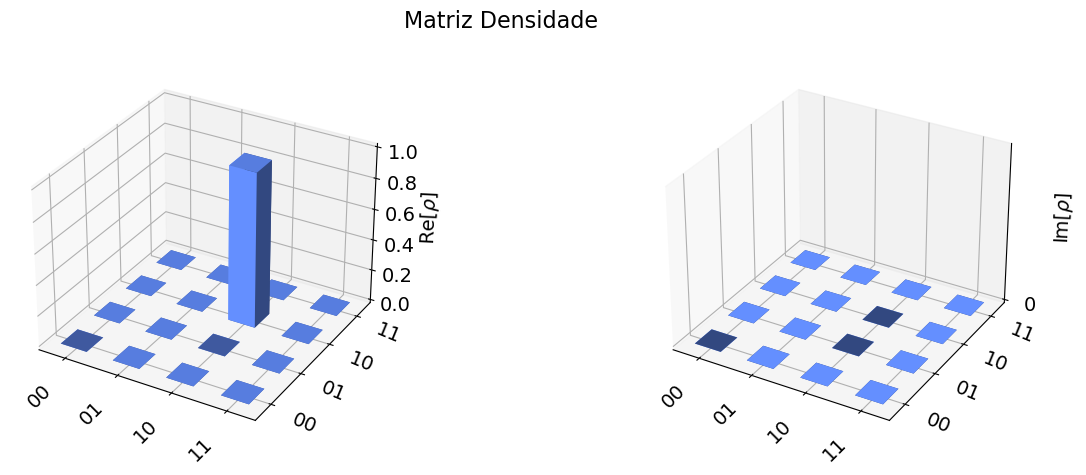

In [66]:
plot_state_city(circuit, title='Matriz Densidade')
